# Проект "Маркетинг"

Интернет-магазин собирает историю покупателей, проводит рассылки предложений и
планирует будущие продажи. Для оптимизации процессов надо выделить пользователей,
которые готовы совершить покупку в ближайшее время.

Цель

Предсказать вероятность покупки в течение 90 дней

Задачи

- Изучить данные
- Разработать полезные признаки
- Создать модель для классификации пользователей
- Улучшить модель и максимизировать метрику roc_auc
- Выполнить тестирование
  
Данные

apparel-purchases история покупок

- client_id идентификатор пользователя
- quantity количество товаров в заказе
- price цена товара
- category_ids вложенные категории, к которым отнсится товар
- date дата покупки
- message_id идентификатор сообщения из рассылки
  
apparel-messages история рекламных рассылок

- bulk_campaign_id идентификатор рекламной кампании
- client_id идентификатор пользователя
- message_id идентификатор сообщений
- event тип действия
- channel канал рассылки
- date дата рассылки
- created_at точное время создания сообщения

apparel-target_binary - совершит ли клиент покупку в течение следующих 90 дней
- client_id идентификатор пользователя
- target целевой признак

## Загрузка и анализ исходных данных

In [2]:
#импорт библиотек
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
from phik import phik_matrix
from phik.report import plot_correlation_matrix
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import (
    accuracy_score,
    recall_score, 
    precision_score,
    confusion_matrix
)
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
import shap
from imblearn.ensemble import BalancedRandomForestClassifier
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline as ImbPipeline

In [104]:
!pip list

Package                   Version
------------------------- --------------
annotated-types           0.7.0
anyio                     4.7.0
argon2-cffi               23.1.0
argon2-cffi-bindings      21.2.0
arrow                     1.3.0
asttokens                 3.0.0
async-lru                 2.0.4
attrs                     24.3.0
babel                     2.16.0
beautifulsoup4            4.9.3
bleach                    6.2.0
Brotli                    1.1.0
cached-property           1.5.2
catboost                  1.2.8
certifi                   2024.12.14
cffi                      1.17.1
charset-normalizer        3.4.0
click                     8.1.7
cloudpickle               3.1.1
colorama                  0.4.6
comm                      0.2.2
contourpy                 1.3.0
cycler                    0.12.1
dacite                    1.9.2
debugpy                   1.8.11
decorator                 5.1.1
defusedxml                0.7.1
entrypoints               0.4
exceptiongroup     

In [3]:
#выгрузим данные о покупках в переменную purchases и выведем 10 строк из полученного датафрейма на экран
purchases = pd.read_csv('C:/Users/Даша/Desktop/DataScientist/Мастерская_2/apparel-purchases.csv')
purchases.head(10)

,client_id,quantity,price,category_ids,date,message_id
0,1515915625468169594,1,1999.0,"['4', '28', '57', '431']",2022-05-16,1515915625468169594-4301-627b661e9736d
1,1515915625468169594,1,2499.0,"['4', '28', '57', '431']",2022-05-16,1515915625468169594-4301-627b661e9736d
2,1515915625471138230,1,6499.0,"['4', '28', '57', '431']",2022-05-16,1515915625471138230-4437-6282242f27843
3,1515915625471138230,1,4999.0,"['4', '28', '244', '432']",2022-05-16,1515915625471138230-4437-6282242f27843
4,1515915625471138230,1,4999.0,"['4', '28', '49', '413']",2022-05-16,1515915625471138230-4437-6282242f27843
5,1515915625471640575,1,3499.0,"['2', '18', '258', '441']",2022-05-16,1515915625471640575-4301-627b661b67ac3
6,1515915625490211585,1,1699.0,"['2', '18', '341', '1311']",2022-05-16,1515915625490211585-4301-627b661843283
7,1515915625490739153,1,1999.0,"['2', '18', '123', '451']",2022-05-16,1515915625490739153-4172-626b943cc789b
8,1515915625491478747,1,999.0,"['5562', '5631', '5549', '667']",2022-05-16,1515915625491478747-4273-6274ceb769d59
9,1515915625491651493,1,699.0,"['5562', '5630', '5649', '678']",2022-05-16,1515915625491651493-4437-6282242f2a9e2


In [4]:
#выгрузим данные о сообщениях в переменную messages и выведем 10 строк из полученного датафрейма на экран
messages = pd.read_csv('C:/Users/Даша/Desktop/DataScientist/Мастерская_2/apparel-messages.csv')
messages.head(10)

,bulk_campaign_id,client_id,message_id,event,channel,date,created_at
0,4439,1515915625626736623,1515915625626736623-4439-6283415ac07ea,open,email,2022-05-19,2022-05-19 00:14:20
1,4439,1515915625490086521,1515915625490086521-4439-62834150016dd,open,email,2022-05-19,2022-05-19 00:39:34
2,4439,1515915625553578558,1515915625553578558-4439-6283415b36b4f,open,email,2022-05-19,2022-05-19 00:51:49
3,4439,1515915625553578558,1515915625553578558-4439-6283415b36b4f,click,email,2022-05-19,2022-05-19 00:52:20
4,4439,1515915625471518311,1515915625471518311-4439-628341570c133,open,email,2022-05-19,2022-05-19 00:56:52
5,4439,1515915625594606468,1515915625594606468-4439-6283411f277fc,open,email,2022-05-19,2022-05-19 01:04:11
6,4439,1515915625491810918,1515915625491810918-4439-6283411d9d299,open,email,2022-05-19,2022-05-19 01:19:54
7,4439,1515915625474219766,1515915625474219766-4439-628341212233a,open,email,2022-05-19,2022-05-19 01:23:43
8,4439,1515915625474219766,1515915625474219766-4439-628341212233a,click,email,2022-05-19,2022-05-19 01:24:16
9,4439,1515915625566741491,1515915625566741491-4439-6283412871599,open,email,2022-05-19,2022-05-19 01:31:06


In [5]:
#выгрузим данные о целевой переменной в переменную target и выведем 10 строк из полученного датафрейма на экран
target = pd.read_csv('C:/Users/Даша/Desktop/DataScientist/Мастерская_2/apparel-target_binary.csv')
target.head(10)

,client_id,target
0,1515915625468060902,0
1,1515915625468061003,1
2,1515915625468061099,0
3,1515915625468061100,0
4,1515915625468061170,0
5,1515915625468061514,0
6,1515915625468061877,0
7,1515915625468061975,0
8,1515915625468061994,0
9,1515915625468062158,0


In [6]:
#выгрузим данные о событиях в переменную event и выведем 10 строк из полученного датафрейма на экран
event = pd.read_csv('C:/Users/Даша/Desktop/DataScientist/Мастерская_2/full_campaign_daily_event.csv')
event.head(10)

,date,bulk_campaign_id,count_click,count_complain,count_hard_bounce,count_open,count_purchase,count_send,count_soft_bounce,count_subscribe,...,nunique_open,nunique_purchase,nunique_send,nunique_soft_bounce,nunique_subscribe,nunique_unsubscribe,count_hbq_spam,nunique_hbq_spam,count_close,nunique_close
0,2022-05-19,563,0,0,0,4,0,0,0,0,...,4,0,0,0,0,0,0,0,0,0
1,2022-05-19,577,0,0,0,1,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
2,2022-05-19,622,0,0,0,2,0,0,0,0,...,2,0,0,0,0,0,0,0,0,0
3,2022-05-19,634,0,0,0,1,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
4,2022-05-19,676,0,0,0,1,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
5,2022-05-19,764,0,0,0,2,0,0,0,0,...,2,0,0,0,0,0,0,0,0,0
6,2022-05-19,766,0,0,0,2,0,0,0,0,...,2,0,0,0,0,0,0,0,0,0
7,2022-05-19,783,1,0,0,8,0,0,0,0,...,6,0,0,0,0,0,0,0,0,0
8,2022-05-19,817,0,0,0,2,0,0,0,0,...,2,0,0,0,0,0,0,0,0,0
9,2022-05-19,833,0,0,0,1,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0


In [7]:
#выгрузим данные о событиях в каналах в переменную event и выведем 10 строк из полученного датафрейма на экран
channel = pd.read_csv('C:/Users/Даша/Desktop/DataScientist/Мастерская_2/full_campaign_daily_event_channel.csv')
channel.head(10)

,date,bulk_campaign_id,count_click_email,count_click_mobile_push,count_open_email,count_open_mobile_push,count_purchase_email,count_purchase_mobile_push,count_soft_bounce_email,count_subscribe_email,...,count_send_email,nunique_hard_bounce_email,nunique_hbq_spam_email,nunique_send_email,count_soft_bounce_mobile_push,nunique_soft_bounce_mobile_push,count_complain_email,nunique_complain_email,count_close_mobile_push,nunique_close_mobile_push
0,2022-05-19,563,0,0,4,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,2022-05-19,577,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,2022-05-19,622,0,0,2,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,2022-05-19,634,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,2022-05-19,676,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5,2022-05-19,764,0,0,2,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
6,2022-05-19,766,0,0,2,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
7,2022-05-19,783,1,0,8,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
8,2022-05-19,817,0,0,2,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9,2022-05-19,833,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [8]:
#выведем информацию о выгруженных данных
purchases.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 202208 entries, 0 to 202207
Data columns (total 6 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   client_id     202208 non-null  int64  
 1   quantity      202208 non-null  int64  
 2   price         202208 non-null  float64
 3   category_ids  202208 non-null  object 
 4   date          202208 non-null  object 
 5   message_id    202208 non-null  object 
dtypes: float64(1), int64(2), object(3)
memory usage: 9.3+ MB


In [9]:
#выведем информацию о выгруженных данных
messages.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12739798 entries, 0 to 12739797
Data columns (total 7 columns):
 #   Column            Dtype 
---  ------            ----- 
 0   bulk_campaign_id  int64 
 1   client_id         int64 
 2   message_id        object
 3   event             object
 4   channel           object
 5   date              object
 6   created_at        object
dtypes: int64(2), object(5)
memory usage: 680.4+ MB


In [10]:
#выведем информацию о выгруженных данных
target.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 49849 entries, 0 to 49848
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype
---  ------     --------------  -----
 0   client_id  49849 non-null  int64
 1   target     49849 non-null  int64
dtypes: int64(2)
memory usage: 779.0 KB


In [11]:
#проверим таблицу purchases на пропуски
purchases.isna().sum()

client_id       0
quantity        0
price           0
category_ids    0
date            0
message_id      0
dtype: int64

In [12]:
#проверим таблицу messages на пропуски
messages.isna().sum()

bulk_campaign_id    0
client_id           0
message_id          0
event               0
channel             0
date                0
created_at          0
dtype: int64

In [13]:
#проверим таблицу target на пропуски
target.isna().sum()

client_id    0
target       0
dtype: int64

In [14]:
#проверим таблицу purchases на явные дубликаты
purchases.duplicated().sum()

73020

In [15]:
purchases[(purchases.duplicated()) & (purchases['client_id'] == 1515915626010261344)]

,client_id,quantity,price,category_ids,date,message_id
202199,1515915626010261344,1,1499.0,"['2', '18', '212', '726']",2024-02-16,1515915626010261344-14648-65cdb6d56c4c8
202200,1515915626010261344,1,1499.0,"['2', '18', '212', '726']",2024-02-16,1515915626010261344-14648-65cdb6d56c4c8
202201,1515915626010261344,1,1499.0,"['2', '18', '212', '726']",2024-02-16,1515915626010261344-14648-65cdb6d56c4c8
202202,1515915626010261344,1,1499.0,"['2', '18', '212', '726']",2024-02-16,1515915626010261344-14648-65cdb6d56c4c8
202203,1515915626010261344,1,1499.0,"['2', '18', '212', '726']",2024-02-16,1515915626010261344-14648-65cdb6d56c4c8


В таблице с продажами найдено 73020 дублирующихся строк. Есть вероятность, что это не реальные дубликаты, а покупки товаров с одинаковой ценой, однаковой категорией и в один и тот же день. Можно представить, что в ячейке category_ids расположены только категории, без артикула товара, то есть путь до уточняющей категории. Рассмотрим на примере клиента с идентификатором 1515915626010261344. В category_ids указано 4 категории ['2', '18', '212', '726'], представим что это: ['Обувь', 'Женская', 'Зимняя', 'Сапоги']. Тогда получается, что клиент купил в этот день 5 разных товаров, но все они имели путь из категорий ['Обувь', 'Женская', 'Зимняя', 'Сапоги']. Стоимость у них тоже могла быть одинаковой, возможно, клиент фильровал товары не более 1499 рублей. Сообщение о рассылке на эти товары тоже могло быть одинаковое, например: "Новая поставка зимней женской обуви". Поэтому считать эти строки явными дубликатами не следует и как вывод: данные строки не подлежат удалению.

In [16]:
#проверим таблицу messages на явные дубликаты
messages.duplicated().sum()

48610

In [17]:
messages[messages.duplicated()]

,bulk_campaign_id,client_id,message_id,event,channel,date,created_at
964232,5723,1515915625554535987,1515915625554535987-5723-62e2af08e00da,click,mobile_push,2022-07-28,2022-07-28 15:58:56
966466,5723,1515915625483569932,1515915625483569932-5723-62e2af0790ad5,click,mobile_push,2022-07-28,2022-07-28 16:07:12
967282,5723,1515915625736038297,1515915625736038297-5723-62e2af0a17cba,click,mobile_push,2022-07-28,2022-07-28 16:09:56
967567,5723,1515915625753898206,1515915625753898206-5723-62e2af0a21ecd,click,mobile_push,2022-07-28,2022-07-28 16:12:24
967904,5723,1515915625626349443,1515915625626349443-5723-62e2af09c0fd3,click,mobile_push,2022-07-28,2022-07-28 16:15:02
...,...,...,...,...,...,...,...
12739558,14657,1515915625566604535,1515915625566604535-14657-65cdd3746b1d9,open,email,2024-02-15,2024-02-15 18:20:59
12739660,14648,1515915625559148104,1515915625559148104-14648-65cdb715ea3dd,click,mobile_push,2024-02-15,2024-02-15 20:10:39
12739720,14600,1515915625468103375,1515915625468103375-14600-65c2038646d16,click,mobile_push,2024-02-15,2024-02-15 21:52:00
12739722,14607,1515915625468103375,1515915625468103375-14607-65c33b1f402bb,click,mobile_push,2024-02-15,2024-02-15 21:52:00


In [18]:
messages[(messages['client_id'] == 1515915625554535987)& (messages['created_at'] == '2022-07-28 15:58:56')]

,bulk_campaign_id,client_id,message_id,event,channel,date,created_at
964231,5723,1515915625554535987,1515915625554535987-5723-62e2af08e00da,click,mobile_push,2022-07-28,2022-07-28 15:58:56
964232,5723,1515915625554535987,1515915625554535987-5723-62e2af08e00da,click,mobile_push,2022-07-28,2022-07-28 15:58:56


В таблице с сообщениями найдено 48610 дубликатов строк. Дубликаты этих сообщений не несут никакой пользы, так как есть вероятность, что это просто повторно отправленные сообщения. Их можно удалить.

In [19]:
#проверим целевую переменную на дисбаланс классов
target['target'].value_counts(normalize = True)

target
0    0.980722
1    0.019278
Name: proportion, dtype: float64

Целевая переменная имеет сильный дисбаланс классов. Для решения данной проблемы решено импользовать модель RandomForestClassifier с настройкой class_weight = 'balanced'.

Данные загружены. Основные таблицы purchases и messages, а также таблица с целевым признаком target. В основных таблицах пропусков в данных не обнаружено. В таблице purchases явные дубликаты решено не удалять, в таблице messages явные дубликаты признаны излишними, удалим их в следующем разделе. У целевой переменной выявлен сильнвй дисбаланс классов, решение данной проблемы представлено.

## Создание новых признаков

Для решения задачи вероятности совершения последующей покупки было решено создать следующие признаки:
- общее количество покупок,
- средний чек покупок,
- сколько раз произведена покупка после рассылки,
- сколько раз подписался на рассылку,
- сколько раз отписался от рассылки,
- сколько раз письмо не было доставлено,
- сколько раз была совершена покупка в разные дни,
- сколько рассылок получено по email,
- сколько рассылок получено по mobile_push,
- покупки по категориям (10 столбцов со значениями категорий из первого значения списка столбца category_ids таблицы purchases)

In [20]:
#создадим новую таблицу
data = target.copy(deep=True)
data.head(10)

,client_id,target
0,1515915625468060902,0
1,1515915625468061003,1
2,1515915625468061099,0
3,1515915625468061100,0
4,1515915625468061170,0
5,1515915625468061514,0
6,1515915625468061877,0
7,1515915625468061975,0
8,1515915625468061994,0
9,1515915625468062158,0


Для моделирования создали отдельную таблицу, в которую вошли данные из исходной таблицы target (client_id, target). 
Также в эту таблицу будут добавлены новые признаки.

In [21]:
#Создадим признак "количество"
count = pd.DataFrame(purchases.groupby('client_id')['quantity'].count())
#Создадим признак "средний чек"
price = pd.DataFrame(purchases.groupby('client_id')['price'].mean())
#Создадим признак "скользо покупок совершено в разные дни"
date_unique = pd.DataFrame(purchases.groupby('client_id')['date'].nunique())

In [22]:
#создадим копию таблицы messages, чтобы производить изменения без последствий для исходных данных
messages_1 = messages.copy(deep=True)

In [23]:
#удалим явные дубликаты, которые выявили в предыдущем разделе
messages_1 = messages_1.drop_duplicates()

In [24]:
#найдем уникальные значения столбца 'event' таблицы messages
messages['event'].sort_values().unique()

array(['click', 'close', 'complain', 'hard_bounce', 'hbq_spam', 'open',
       'purchase', 'send', 'soft_bounce', 'subscribe', 'unsubscribe'],
      dtype=object)

click — клик (переход по ссылке в письме);

close — закрытие (письма/окна);

complain — жалоба (отметка «Это спам» или аналогичное действие пользователя);

hard_bounce — жёсткий отскок (недоставка письма из‑за несуществующего адреса);

hbq_spam — спам в очереди жёстких отскоков (письмо помечено как спам при жёстком отскоке);

open — открытие (письма);

purchase — покупка (совершение заказа/транзакции);

send — отправка (письма);

soft_bounce — мягкий отскок (временная недоставка письма, например, из‑за переполненного ящика);

subscribe — подписка (оформление подписки на рассылку);

unsubscribe — отписка (отмена подписки на рассылку).

In [25]:
#найдем уникальные значения столбца 'event' таблицы messages
messages['channel'].sort_values().unique()

array(['email', 'mobile_push'], dtype=object)

In [26]:
#создадим признак "Сколько раз была совершена покупка после рассылки"
messages_1['purchase'] = messages['event'].apply(lambda x: 1  if x == 'purchase' else 0)

In [27]:
#создадим датафрейм для признака "Сколько раз была совершена покупка после рассылки"
purchase = pd.DataFrame(messages_1.groupby('client_id')['purchase'].sum())
purchase.head(5)

,purchase
client_id,
1515915625468060902,5
1515915625468061003,1
1515915625468061099,0
1515915625468061100,1
1515915625468061170,3


In [28]:
#создадим признак "Сколько раз покупатель подписался на рассылку"
messages_1['subscribe'] = messages['event'].apply(lambda x: 1  if x == 'subscribe' else 0)

In [29]:
#создадим датафрейм для признака "Сколько раз покупатель подписался на рассылку"
subscribe = pd.DataFrame(messages_1.groupby('client_id')['subscribe'].sum())
subscribe.head(5)

,subscribe
client_id,
1515915625468060902,0
1515915625468061003,0
1515915625468061099,0
1515915625468061100,0
1515915625468061170,0


In [30]:
#создадим признак "Сколько раз покупатель отписался от рассылки"
messages_1['unsubscribe'] = messages['event'].apply(lambda x: 1  if x == 'unsubscribe' else 0)

In [31]:
#создадим датафрейм для признака "Сколько раз покупатель отписался от рассылки"
unsubscribe = pd.DataFrame(messages_1.groupby('client_id')['unsubscribe'].sum())
unsubscribe.head(5)

,unsubscribe
client_id,
1515915625468060902,1
1515915625468061003,0
1515915625468061099,0
1515915625468061100,0
1515915625468061170,0


In [32]:
#создадим признак "Сколько раз письмо не было доставлено из-за неправильного адреса"
messages_1['hard_bounce'] = messages['event'].apply(lambda x: 1  if x == 'hard_bounce' else 0)

In [33]:
#создадим датафрейм для признака "Сколько раз письмо не было доставлено из-за неправильного адреса"
hard_bounce = pd.DataFrame(messages_1.groupby('client_id')['hard_bounce'].sum())
hard_bounce.head(5)

,hard_bounce
client_id,
1515915625468060902,0
1515915625468061003,0
1515915625468061099,2
1515915625468061100,1
1515915625468061170,0


In [34]:
#создадим признак "Сколько сообщений получено по email"
messages_1['email'] = messages['channel'].apply(lambda x: 1  if x == 'email' else 0)

In [35]:
#создадим датафрейм для признака "Сколько сообщений получено по email"
email = pd.DataFrame(messages_1.groupby('client_id')['email'].sum())
email.head(5)

,email
client_id,
1515915625468060902,177
1515915625468061003,165
1515915625468061099,182
1515915625468061100,0
1515915625468061170,202


In [36]:
#создадим признак "Сколько сообщений получено mobile_push"
messages_1['mobile_push'] = messages['channel'].apply(lambda x: 1  if x == 'mobile_push' else 0)

In [37]:
#создадим датафрейм для признака Сколько сообщений получено по mobile_push"
mobile_push = pd.DataFrame(messages_1.groupby('client_id')['mobile_push'].sum())
mobile_push.head(5)

,mobile_push
client_id,
1515915625468060902,0
1515915625468061003,0
1515915625468061099,94
1515915625468061100,428
1515915625468061170,91


In [38]:
#создадим копию таблицы purchases, чтобы производить изменения без последствий для исходных данных
purchases_1 = purchases.copy(deep=True)

In [39]:
#Выделим 5 новых столбцов с категориями из category_ids
purchases_1[['cat1', 'cat2', 'cat3', 'cat4', 'cat5']] = purchases_1['category_ids'].str.split(', ', expand=True)
purchases_1.head(10)

,client_id,quantity,price,category_ids,date,message_id,cat1,cat2,cat3,cat4,cat5
0,1515915625468169594,1,1999.0,"['4', '28', '57', '431']",2022-05-16,1515915625468169594-4301-627b661e9736d,['4','28','57','431'],None
1,1515915625468169594,1,2499.0,"['4', '28', '57', '431']",2022-05-16,1515915625468169594-4301-627b661e9736d,['4','28','57','431'],None
2,1515915625471138230,1,6499.0,"['4', '28', '57', '431']",2022-05-16,1515915625471138230-4437-6282242f27843,['4','28','57','431'],None
3,1515915625471138230,1,4999.0,"['4', '28', '244', '432']",2022-05-16,1515915625471138230-4437-6282242f27843,['4','28','244','432'],None
4,1515915625471138230,1,4999.0,"['4', '28', '49', '413']",2022-05-16,1515915625471138230-4437-6282242f27843,['4','28','49','413'],None
5,1515915625471640575,1,3499.0,"['2', '18', '258', '441']",2022-05-16,1515915625471640575-4301-627b661b67ac3,['2','18','258','441'],None
6,1515915625490211585,1,1699.0,"['2', '18', '341', '1311']",2022-05-16,1515915625490211585-4301-627b661843283,['2','18','341','1311'],None
7,1515915625490739153,1,1999.0,"['2', '18', '123', '451']",2022-05-16,1515915625490739153-4172-626b943cc789b,['2','18','123','451'],None
8,1515915625491478747,1,999.0,"['5562', '5631', '5549', '667']",2022-05-16,1515915625491478747-4273-6274ceb769d59,['5562','5631','5549','667'],None
9,1515915625491651493,1,699.0,"['5562', '5630', '5649', '678']",2022-05-16,1515915625491651493-4437-6282242f2a9e2,['5562','5630','5649','678'],None


In [40]:
#выведем информацию о датасете
purchases_1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 202208 entries, 0 to 202207
Data columns (total 11 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   client_id     202208 non-null  int64  
 1   quantity      202208 non-null  int64  
 2   price         202208 non-null  float64
 3   category_ids  202208 non-null  object 
 4   date          202208 non-null  object 
 5   message_id    202208 non-null  object 
 6   cat1          202208 non-null  object 
 7   cat2          195365 non-null  object 
 8   cat3          195365 non-null  object 
 9   cat4          194009 non-null  object 
 10  cat5          518 non-null     object 
dtypes: float64(1), int64(2), object(8)
memory usage: 17.0+ MB


На основе полученных данных можно заключить, что cat1 имеет максимально полные данные. 
Согласно техническому заданию маркер распродажи, а также разделение на базовые катогерии находится в первом элементе списка категорий, поэтому дальнейший анализ будем производить основываясь на данных, выгруженных в столбец cat1.

In [41]:
#удалим лишние знаки из столбца cat1
purchases_1['cat1'] = purchases_1['cat1'].str.replace("[", '')
purchases_1['cat1'] = purchases_1['cat1'].str.replace("'", "")
purchases_1.head(10)

,client_id,quantity,price,category_ids,date,message_id,cat1,cat2,cat3,cat4,cat5
0,1515915625468169594,1,1999.0,"['4', '28', '57', '431']",2022-05-16,1515915625468169594-4301-627b661e9736d,4,'28','57','431'],None
1,1515915625468169594,1,2499.0,"['4', '28', '57', '431']",2022-05-16,1515915625468169594-4301-627b661e9736d,4,'28','57','431'],None
2,1515915625471138230,1,6499.0,"['4', '28', '57', '431']",2022-05-16,1515915625471138230-4437-6282242f27843,4,'28','57','431'],None
3,1515915625471138230,1,4999.0,"['4', '28', '244', '432']",2022-05-16,1515915625471138230-4437-6282242f27843,4,'28','244','432'],None
4,1515915625471138230,1,4999.0,"['4', '28', '49', '413']",2022-05-16,1515915625471138230-4437-6282242f27843,4,'28','49','413'],None
5,1515915625471640575,1,3499.0,"['2', '18', '258', '441']",2022-05-16,1515915625471640575-4301-627b661b67ac3,2,'18','258','441'],None
6,1515915625490211585,1,1699.0,"['2', '18', '341', '1311']",2022-05-16,1515915625490211585-4301-627b661843283,2,'18','341','1311'],None
7,1515915625490739153,1,1999.0,"['2', '18', '123', '451']",2022-05-16,1515915625490739153-4172-626b943cc789b,2,'18','123','451'],None
8,1515915625491478747,1,999.0,"['5562', '5631', '5549', '667']",2022-05-16,1515915625491478747-4273-6274ceb769d59,5562,'5631','5549','667'],None
9,1515915625491651493,1,699.0,"['5562', '5630', '5649', '678']",2022-05-16,1515915625491651493-4437-6282242f2a9e2,5562,'5630','5649','678'],None


In [42]:
#выведем уникальные значения столбца cat1
purchases_1['cat1'].sort_values().unique()

array(['1', '2', '3', '4', '5', '5562', '5963', '6060', 'None]', ']'],
      dtype=object)

In [43]:
#рассмотрим распределение значений во всем датасете
purchases_1['cat1'].value_counts()

cat1
4        112578
5562      46511
2         27429
6060       7559
]          5579
5963       1272
None]      1264
3            11
1             3
5             2
Name: count, dtype: int64

В списке значений столбца cat1 присутствуют значения 'None]' и ']'. 
Столбец имеет текстовый тип данных, поэтому мы воспринимает эти значение как обозначение категорий "Без категории" и "Категория не указана", соответственно.

In [44]:
#создадим признак "Категория 1"
purchases_1['category1'] = purchases_1['cat1'].apply(lambda x: 1  if x == '1' else 0)

In [45]:
#создадим датафрейм для признака "Категория 1"
category1 = pd.DataFrame(purchases_1.groupby('client_id')['category1'].sum())
category1.sort_values(by='category1', ascending=False).head(10)

,category1
client_id,
1515915625789566616,1
1515915625489044168,1
1515915625666901395,1
1515915625585871835,0
1515915625586017983,0
1515915625585983689,0
1515915625585987595,0
1515915625585989787,0
1515915625586001761,0


In [46]:
#создадим признак "Категория 2"
purchases_1['category2'] = purchases_1['cat1'].apply(lambda x: 1  if x == '2' else 0)

In [47]:
#создадим датафрейм для признака "Категория 2"
category2 = pd.DataFrame(purchases_1.groupby('client_id')['category2'].sum())
category2.sort_values(by='category2', ascending=False).head(10)

,category2
client_id,
1515915625634092896,62
1515915625853312319,59
1515915625558691508,56
1515915626005555432,48
1515915625590683857,43
1515915625977614743,36
1515915625474407101,34
1515915625587520207,34
1515915625589031166,33


In [48]:
#создадим признак "Категория 3"
purchases_1['category3'] = purchases_1['cat1'].apply(lambda x: 1  if x == '3' else 0)

In [49]:
#создадим датафрейм для признака "Категория 3"
category3 = pd.DataFrame(purchases_1.groupby('client_id')['category3'].sum())
category3.sort_values(by='category3', ascending=False).head(10)

,category3
client_id,
1515915625928604160,2
1515915625766046134,2
1515915625503627622,2
1515915625862933230,2
1515915625585330745,2
1515915625759495104,1
1515915625586017903,0
1515915625585983689,0
1515915625585987595,0


In [50]:
#создадим признак "Категория 4"
purchases_1['category4'] = purchases_1['cat1'].apply(lambda x: 1  if x == '4' else 0)

In [51]:
#создадим датафрейм для признака "Категория 4"
category4 = pd.DataFrame(purchases_1.groupby('client_id')['category4'].sum())
category4.sort_values(by='category4', ascending=False).head(10)

,category4
client_id,
1515915625853312319,218
1515915625500232103,111
1515915625491750681,110
1515915625557342756,84
1515915625912328708,79
1515915625490352441,75
1515915625475422624,73
1515915625586986524,69
1515915625470860261,68


In [52]:
#создадим признак "Категория 5"
purchases_1['category5'] = purchases_1['cat1'].apply(lambda x: 1  if x == '5' else 0)

In [53]:
#создадим датафрейм для признака "Категория 5"
category5 = pd.DataFrame(purchases_1.groupby('client_id')['category5'].sum())
category5.sort_values(by='category5', ascending=False).head(10)

,category5
client_id,
1515915625500375788,2
1515915625468060902,0
1515915625586011076,0
1515915625585956901,0
1515915625585957439,0
1515915625585959517,0
1515915625585965079,0
1515915625585983689,0
1515915625585987595,0


In [54]:
#создадим признак "Категория 6"
purchases_1['category6'] = purchases_1['cat1'].apply(lambda x: 1  if x == '5562' else 0)

In [55]:
#создадим датафрейм для признака "Категория 6"
category6 = pd.DataFrame(purchases_1.groupby('client_id')['category6'].sum())
category6.sort_values(by='category6', ascending=False).head(10)

,category6
client_id,
1515915625607113301,199
1515915625624308268,198
1515915625488041632,96
1515915625470883759,87
1515915625559931867,78
1515915625558517454,72
1515915625491335784,66
1515915625577756131,64
1515915625500440898,63


In [56]:
#создадим признак "Категория 7"
purchases_1['category7'] = purchases_1['cat1'].apply(lambda x: 1  if x == '5963' else 0)

In [57]:
#создадим датафрейм для признака "Категория 7"
category7 = pd.DataFrame(purchases_1.groupby('client_id')['category7'].sum())
category7.sort_values(by='category7', ascending=False).head(10)

,category7
client_id,
1515915625490352441,28
1515915625978387318,15
1515915625853865046,14
1515915625930042215,12
1515915625550883365,11
1515915625985463281,8
1515915626008004463,8
1515915625582899459,8
1515915625490223646,7


In [58]:
#создадим признак "Категория 8"
purchases_1['category8'] = purchases_1['cat1'].apply(lambda x: 1  if x == '6060' else 0)

In [59]:
#создадим датафрейм для признака "Категория 8"
category8 = pd.DataFrame(purchases_1.groupby('client_id')['category8'].sum())
category8.sort_values(by='category8', ascending=False).head(10)

,category8
client_id,
1515915625853312319,65
1515915625476550033,34
1515915625491338492,30
1515915625546154180,30
1515915625581876197,28
1515915625590657267,28
1515915625702668631,26
1515915625601580916,26
1515915625489179882,24


In [60]:
#создадим признак "Категория 9"
purchases_1['category9'] = purchases_1['cat1'].apply(lambda x: 1  if x == 'None]' else 0)

In [61]:
#создадим датафрейм для признака "Категория 9"
category9 = pd.DataFrame(purchases_1.groupby('client_id')['category9'].sum())
category9.sort_values(by='category9', ascending=False).head(10)

,category9
client_id,
1515915625489249661,9
1515915625587925875,6
1515915625633771121,6
1515915625501695878,6
1515915625539302643,4
1515915625468125168,4
1515915625549584822,4
1515915625502317037,4
1515915625468189048,4


In [62]:
#создадим признак "Категория 10"
purchases_1['category10'] = purchases_1['cat1'].apply(lambda x: 1  if x == ']' else 0)

In [63]:
#создадим датафрейм для признака "Категория 10"
category10 = pd.DataFrame(purchases_1.groupby('client_id')['category10'].sum())
category10.sort_values(by='category10', ascending=False).head(10)

,category10
client_id,
1515915625983356708,15
1515915625468102493,10
1515915625637550888,10
1515915625637009837,8
1515915625958582677,8
1515915625490573906,8
1515915625490018348,8
1515915625500458864,7
1515915625500321440,7


Объединим полученные признаки в один датафрейм, который будем использовать в последующем моделировании.

In [64]:
#объединение признаков
data = pd.merge(data, count, on='client_id', how='left')
data = pd.merge(data, price, on='client_id', how='left')
data = pd.merge(data, purchase, on='client_id', how='left')
data = pd.merge(data, subscribe, on='client_id', how='left')
data = pd.merge(data, unsubscribe, on='client_id', how='left')
data = pd.merge(data, hard_bounce, on='client_id', how='left')
data = pd.merge(data, date_unique, on='client_id', how='left')
data = pd.merge(data, email, on='client_id', how='left')
data = pd.merge(data, mobile_push, on='client_id', how='left')
data = pd.merge(data, category1, on='client_id', how='left')
data = pd.merge(data, category2, on='client_id', how='left')
data = pd.merge(data, category3, on='client_id', how='left')
data = pd.merge(data, category4, on='client_id', how='left')
data = pd.merge(data, category5, on='client_id', how='left')
data = pd.merge(data, category6, on='client_id', how='left')
data = pd.merge(data, category7, on='client_id', how='left')
data = pd.merge(data, category8, on='client_id', how='left')
data = pd.merge(data, category9, on='client_id', how='left')
data = pd.merge(data, category10, on='client_id', how='left')
data.head(10)

,client_id,target,quantity,price,purchase,subscribe,unsubscribe,hard_bounce,date,email,...,category1,category2,category3,category4,category5,category6,category7,category8,category9,category10
0,1515915625468060902,0,7,999.000000,5.0,0.0,1.0,0.0,1,177.0,...,0,0,0,7,0,0,0,0,0,0
1,1515915625468061003,1,7,2319.285714,1.0,0.0,0.0,0.0,1,165.0,...,0,0,0,7,0,0,0,0,0,0
2,1515915625468061099,0,1,299.000000,0.0,0.0,0.0,2.0,1,182.0,...,0,0,0,1,0,0,0,0,0,0
3,1515915625468061100,0,2,1049.000000,1.0,0.0,0.0,1.0,1,0.0,...,0,0,0,2,0,0,0,0,0,0
4,1515915625468061170,0,19,1768.473684,3.0,0.0,0.0,0.0,3,202.0,...,0,2,0,15,0,0,0,0,0,2
5,1515915625468061514,0,1,999.000000,1.0,0.0,0.0,0.0,1,180.0,...,0,0,0,1,0,0,0,0,0,0
6,1515915625468061877,0,1,1499.000000,1.0,0.0,0.0,0.0,1,67.0,...,0,0,0,0,0,1,0,0,0,0
7,1515915625468061975,0,1,299.000000,1.0,0.0,0.0,0.0,1,180.0,...,0,0,0,1,0,0,0,0,0,0
8,1515915625468061994,0,8,126.500000,2.0,0.0,0.0,0.0,2,96.0,...,0,0,0,0,0,1,0,7,0,0
9,1515915625468062158,0,4,1524.000000,2.0,0.0,0.0,0.0,2,172.0,...,0,0,0,4,0,0,0,0,0,0


In [65]:
#переименуем столбцы
data = data.rename(columns={'quantity': 'count_purchases', 'purchase': 'purchase_after_event', 'subscribe': 'subscribe_after_event', 
                            'unsubscribe': 'unsubscribe_after_event', 'hard_bounce': 'hard_bounce_after_event', 'date': 'date_unique'})
data.head(10)

,client_id,target,count_purchases,price,purchase_after_event,subscribe_after_event,unsubscribe_after_event,hard_bounce_after_event,date_unique,email,...,category1,category2,category3,category4,category5,category6,category7,category8,category9,category10
0,1515915625468060902,0,7,999.000000,5.0,0.0,1.0,0.0,1,177.0,...,0,0,0,7,0,0,0,0,0,0
1,1515915625468061003,1,7,2319.285714,1.0,0.0,0.0,0.0,1,165.0,...,0,0,0,7,0,0,0,0,0,0
2,1515915625468061099,0,1,299.000000,0.0,0.0,0.0,2.0,1,182.0,...,0,0,0,1,0,0,0,0,0,0
3,1515915625468061100,0,2,1049.000000,1.0,0.0,0.0,1.0,1,0.0,...,0,0,0,2,0,0,0,0,0,0
4,1515915625468061170,0,19,1768.473684,3.0,0.0,0.0,0.0,3,202.0,...,0,2,0,15,0,0,0,0,0,2
5,1515915625468061514,0,1,999.000000,1.0,0.0,0.0,0.0,1,180.0,...,0,0,0,1,0,0,0,0,0,0
6,1515915625468061877,0,1,1499.000000,1.0,0.0,0.0,0.0,1,67.0,...,0,0,0,0,0,1,0,0,0,0
7,1515915625468061975,0,1,299.000000,1.0,0.0,0.0,0.0,1,180.0,...,0,0,0,1,0,0,0,0,0,0
8,1515915625468061994,0,8,126.500000,2.0,0.0,0.0,0.0,2,96.0,...,0,0,0,0,0,1,0,7,0,0
9,1515915625468062158,0,4,1524.000000,2.0,0.0,0.0,0.0,2,172.0,...,0,0,0,4,0,0,0,0,0,0


In [66]:
#выведем информацию о созданном датасете
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 49849 entries, 0 to 49848
Data columns (total 21 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   client_id                49849 non-null  int64  
 1   target                   49849 non-null  int64  
 2   count_purchases          49849 non-null  int64  
 3   price                    49849 non-null  float64
 4   purchase_after_event     41982 non-null  float64
 5   subscribe_after_event    41982 non-null  float64
 6   unsubscribe_after_event  41982 non-null  float64
 7   hard_bounce_after_event  41982 non-null  float64
 8   date_unique              49849 non-null  int64  
 9   email                    41982 non-null  float64
 10  mobile_push              41982 non-null  float64
 11  category1                49849 non-null  int64  
 12  category2                49849 non-null  int64  
 13  category3                49849 non-null  int64  
 14  category4             

In [67]:
#проверим на наличие пропусков
data.isna().sum()

client_id                     0
target                        0
count_purchases               0
price                         0
purchase_after_event       7867
subscribe_after_event      7867
unsubscribe_after_event    7867
hard_bounce_after_event    7867
date_unique                   0
email                      7867
mobile_push                7867
category1                     0
category2                     0
category3                     0
category4                     0
category5                     0
category6                     0
category7                     0
category8                     0
category9                     0
category10                    0
dtype: int64

In [68]:
#выведем данные с пропусками
data[data['purchase_after_event'].isna()]

,client_id,target,count_purchases,price,purchase_after_event,subscribe_after_event,unsubscribe_after_event,hard_bounce_after_event,date_unique,email,...,category1,category2,category3,category4,category5,category6,category7,category8,category9,category10
293,1515915625468081882,0,5,1584.800000,NaN,NaN,NaN,NaN,1,NaN,...,0,0,0,3,0,0,0,0,0,2
347,1515915625468087979,0,13,194.384615,NaN,NaN,NaN,NaN,1,NaN,...,0,0,0,7,0,6,0,0,0,0
418,1515915625468093885,1,35,2526.628571,NaN,NaN,NaN,NaN,9,NaN,...,0,2,0,33,0,0,0,0,0,0
564,1515915625468105189,0,7,1256.142857,NaN,NaN,NaN,NaN,2,NaN,...,0,0,0,7,0,0,0,0,0,0
777,1515915625468122963,0,1,2399.000000,NaN,NaN,NaN,NaN,1,NaN,...,0,0,0,1,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
49843,1515915626010256069,0,2,1999.000000,NaN,NaN,NaN,NaN,1,NaN,...,0,0,0,0,0,2,0,0,0,0
49845,1515915626010266132,0,2,909.000000,NaN,NaN,NaN,NaN,1,NaN,...,0,0,0,2,0,0,0,0,0,0
49846,1515915626010439406,0,2,99.000000,NaN,NaN,NaN,NaN,1,NaN,...,0,0,0,2,0,0,0,0,0,0
49847,1515915626010443527,0,1,1999.000000,NaN,NaN,NaN,NaN,1,NaN,...,0,1,0,0,0,0,0,0,0,0


In [69]:
#проверим есть ли эти client_id в таблице messages
messages[messages['client_id'] == 1515915626010443527]

,bulk_campaign_id,client_id,message_id,event,channel,date,created_at


Из полученных данных можно заключить, что некоторые client_id из таблицы target отсутствуют в таблице messages, поэтому в итоговой таблице присутствуют пропуски. Следует заменить их на значение 0.

In [70]:
#заменим пропуски значением 0
data = data.fillna(0)
data.isna().sum()

client_id                  0
target                     0
count_purchases            0
price                      0
purchase_after_event       0
subscribe_after_event      0
unsubscribe_after_event    0
hard_bounce_after_event    0
date_unique                0
email                      0
mobile_push                0
category1                  0
category2                  0
category3                  0
category4                  0
category5                  0
category6                  0
category7                  0
category8                  0
category9                  0
category10                 0
dtype: int64

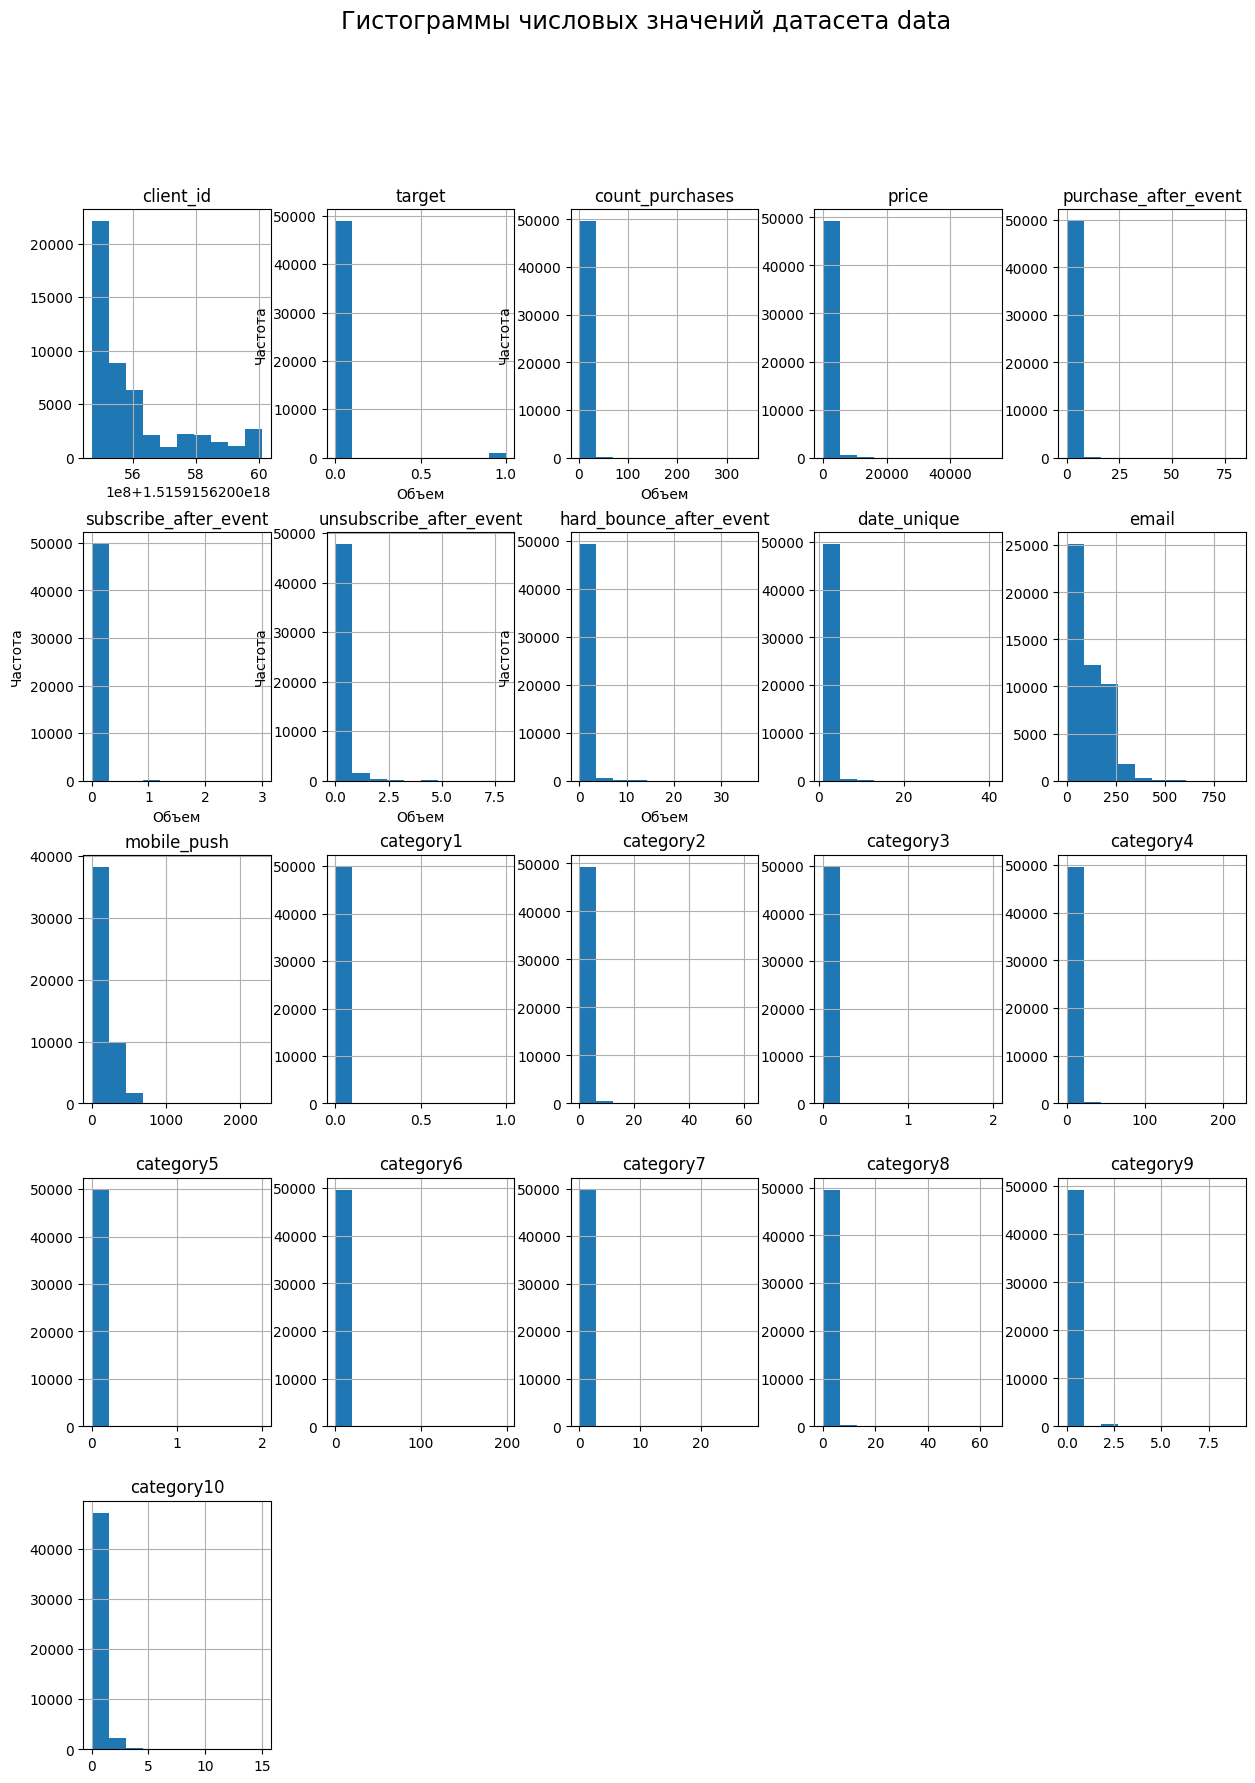

In [72]:
#выведем гистограммы числовых значений датасета data
axes = data.hist(figsize=(15, 20));
plt.suptitle('Гистограммы числовых значений датасета data', ha='center', fontsize='xx-large')
axes[0,1].set_xlabel('Объем')
axes[0,1].set_ylabel('Частота')
axes[0,2].set_xlabel('Объем')
axes[0,2].set_ylabel('Частота')
axes[1,0].set_xlabel('Объем')
axes[1,0].set_ylabel('Частота')
axes[1,1].set_xlabel('Объем')
axes[1,1].set_ylabel('Частота')
axes[1,2].set_xlabel('Объем')
axes[1,2].set_ylabel('Частота')
plt.show()

Распределение данных в столбцах датасета data неравномерное, имеются выбросы, но удалять их нельзя, так как все они учитываются в исходном целевом датасете target.

interval columns not set, guessing: ['target', 'count_purchases', 'price', 'purchase_after_event', 'subscribe_after_event', 'unsubscribe_after_event', 'hard_bounce_after_event', 'date_unique', 'email', 'mobile_push', 'category1', 'category2', 'category3', 'category4', 'category5', 'category6', 'category7', 'category8', 'category9', 'category10']


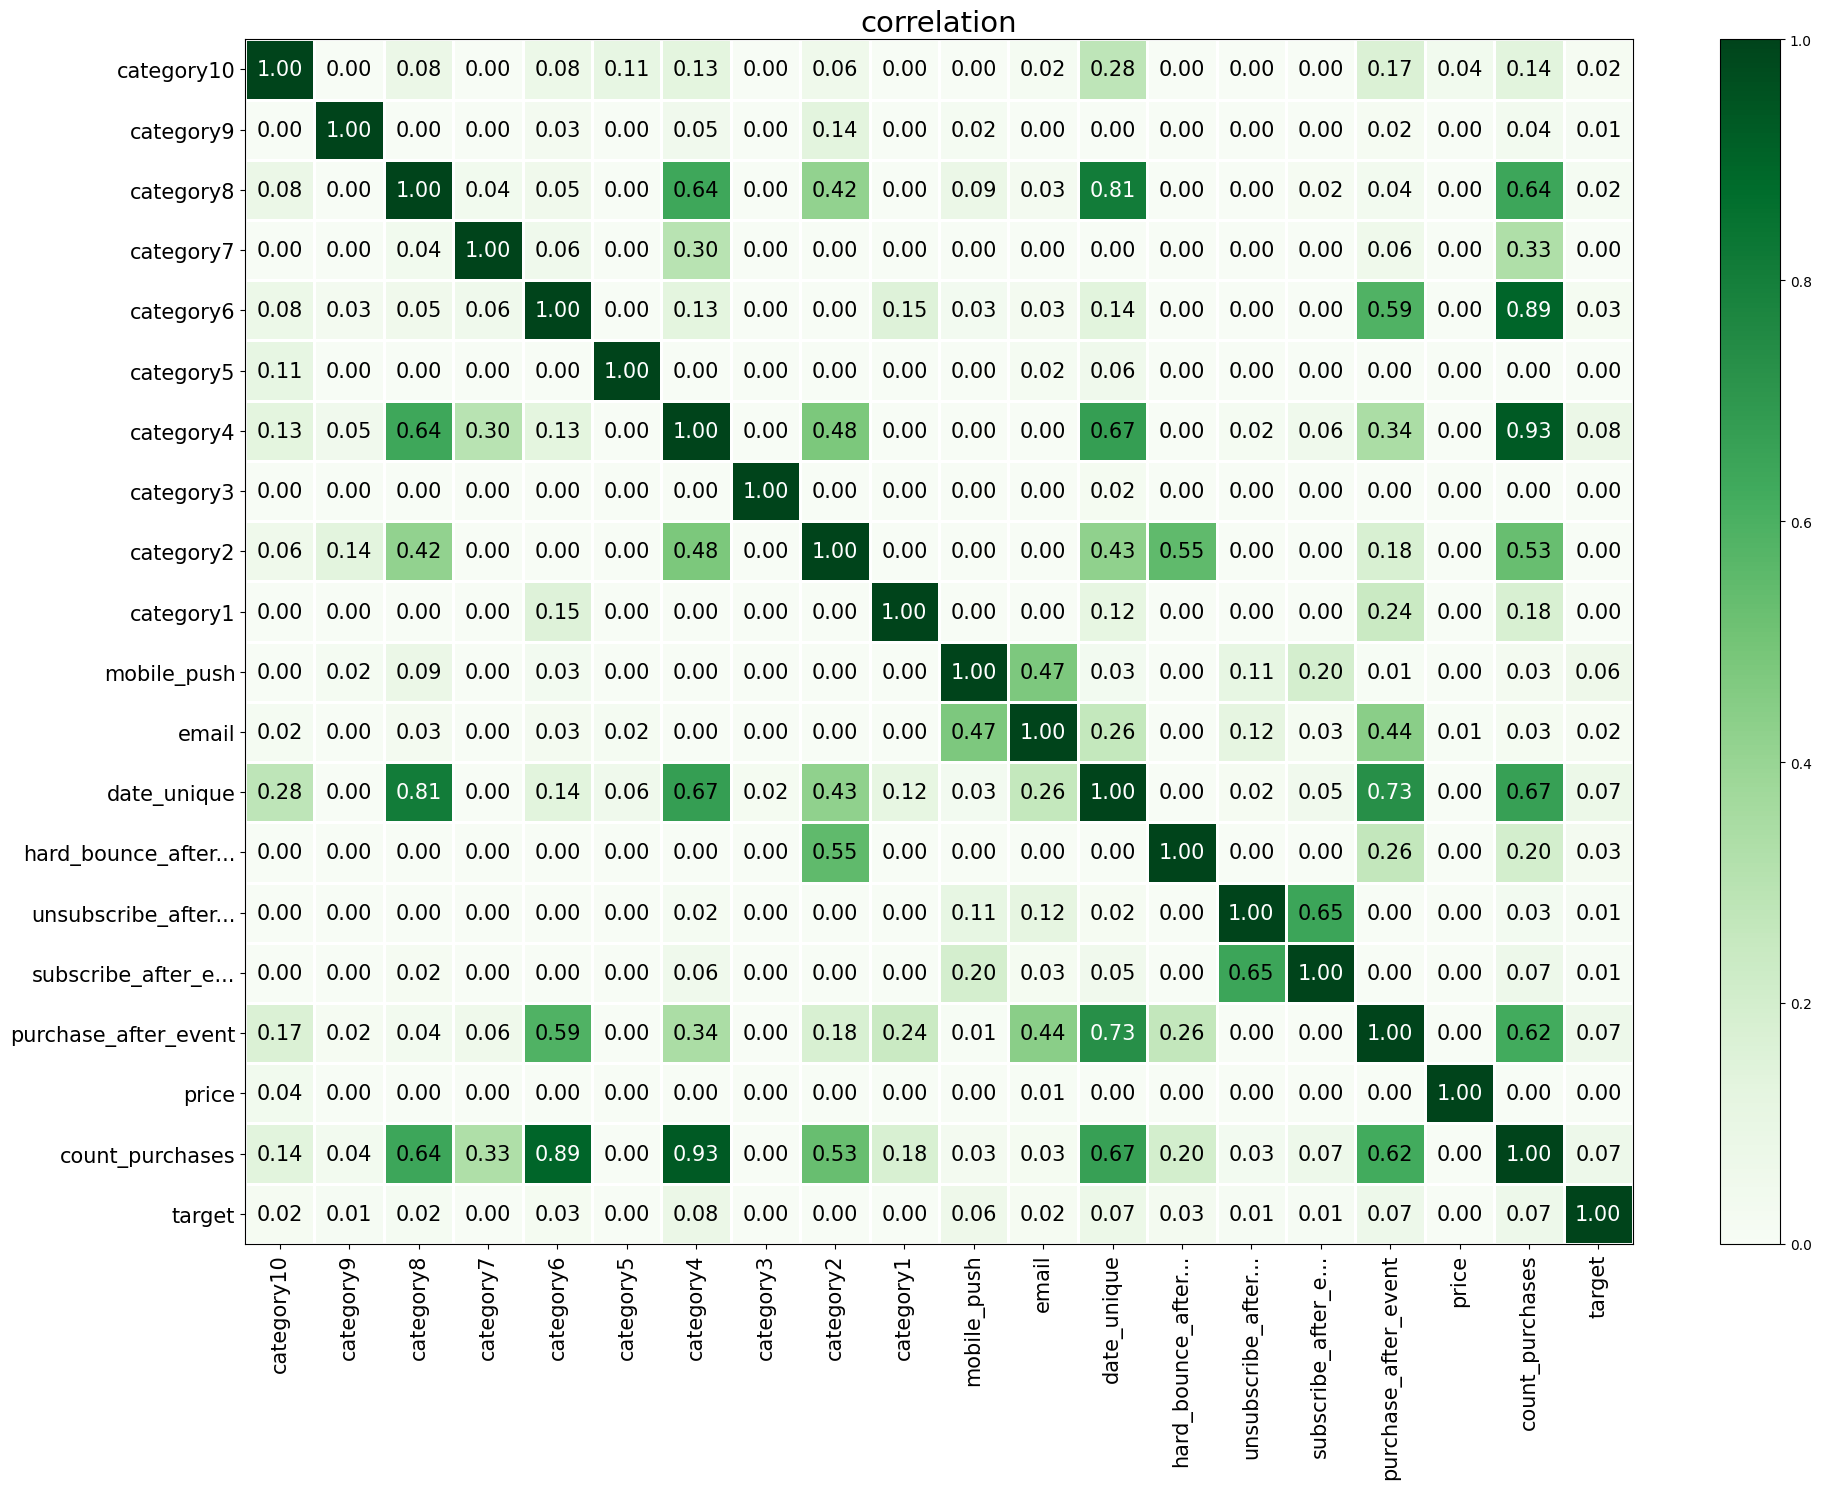

In [75]:
#построим тепловую карту корреляции признаков
matrix = phik_matrix(data.drop(['client_id'], axis=1));
plot_correlation_matrix(
    matrix.values,
    x_labels=matrix.columns,
    y_labels=matrix.index,
    vmin=0, vmax=1, color_map='Greens',
    title=r'correlation',
    fontsize_factor=1.5,
    figsize=(20, 15)
) 

Создан датафрейм data с 19 признаками, пропуски замененны на значение 0, построена матрица корреляции, которая показывает несильную зависимость целевой переменной, он созданных признаков. Следует применить другой метод анализа признаков. В данном проекте будет использован метод SHAP.

## Моделирование и прогноз

In [77]:
#зададим константы
RANDOM_STATE = 77
TEST_SIZE = 0.25

In [78]:
#разделим датафрейм на признаки и целевую переменную
X = data.drop(['client_id','target'], axis=1)
y = data['target']

In [79]:
#разделим данные на тренировочную и тестовую выборки
X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size = TEST_SIZE, 
    random_state = RANDOM_STATE,
    stratify = y)

In [81]:
# создадим список с названиями признаков
num_columns = ['count_purchases', 'subscribe_after_event', 'price', 'purchase_after_event', 'unsubscribe_after_event', 'hard_bounce_after_event',
               'date_unique', 'email', 'mobile_push', 'category2', 'category4', 'category6', 'category7', 
              'category8', 'category9', 'category10', 'category1', 'category3', 'category5']

In [82]:
# создаём общий пайплайн для подготовки данных
data_preprocessor = ColumnTransformer(
    [     ('num', MinMaxScaler(), num_columns)
    ],
    remainder='passthrough'
)

In [83]:
# создаём итоговый пайплайн: подготовка данных и модель
pipe_final = Pipeline([
    ('preprocessor', data_preprocessor),
    ('models', DecisionTreeClassifier(random_state=RANDOM_STATE))
])

param_grid = [
   
    # словарь для модели RandomForestClassifier
    {
        'models': [RandomForestClassifier(
            random_state=RANDOM_STATE,
            class_weight='balanced'
        )],
        'models__n_estimators': [10, 50, 100],
        'models__max_depth': [None, 5, 10],
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']
    }
]

In [84]:
#создадим кросс-валидацию RandomizedSearchCV
randomized_search = RandomizedSearchCV(
    pipe_final,
    param_grid,
    cv=5,
    scoring='roc_auc',
    random_state=RANDOM_STATE,
    n_jobs=-1
)

In [85]:
#обучаем модель
randomized_search.fit(X_train, y_train)

RandomizedSearchCV(cv=5,
                   estimator=Pipeline(steps=[('preprocessor',
                                              ColumnTransformer(remainder='passthrough',
                                                                transformers=[('num',
                                                                               MinMaxScaler(),
                                                                               ['count_purchases',
                                                                                'subscribe_after_event',
                                                                                'price',
                                                                                'purchase_after_event',
                                                                                'unsubscribe_after_event',
                                                                                'hard_bounce_after_event',
                                                                                'date_unique',
                                                                                'email',
                                                                                'mobile_push',
                                                                                'category2',
                                                                                'category4',
                                                                                'category6',
                                                                                'categor...
                                             ('models',
                                              DecisionTreeClassifier(random_state=77))]),
                   n_jobs=-1,
                   param_distributions=[{'models': [RandomForestClassifier(class_weight='balanced',
                                                                           max_depth=5,
                                                                           n_estimators=50,
                                                                           random_state=77)],
                                         'models__max_depth': [None, 5, 10],
                                         'models__n_estimators': [10, 50, 100],
                                         'preprocessor__num': [StandardScaler(),
                                                               MinMaxScaler(),
                                                               'passthrough']}],
                   random_state=77, scoring='roc_auc')

In [86]:
print('Лучшая модель и её параметры:\n\n', randomized_search.best_estimator_)
print ('Метрика лучшей модели на кросс-валидации:', randomized_search.best_score_)

Лучшая модель и её параметры:

 Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('num', MinMaxScaler(),
                                                  ['count_purchases',
                                                   'subscribe_after_event',
                                                   'price',
                                                   'purchase_after_event',
                                                   'unsubscribe_after_event',
                                                   'hard_bounce_after_event',
                                                   'date_unique', 'email',
                                                   'mobile_push', 'category2',
                                                   'category4', 'category6',
                                                   'category7', 'category8',
                                                   'categ

In [89]:
#вычисляем предсказание predict_proba
y_test_pred = randomized_search.predict_proba(X_test)[:, 1]
print(f'Метрика ROC-AUC на тестовой выборке: {roc_auc_score(y_test, y_test_pred).round(2)}')

Метрика ROC-AUC на тестовой выборке: 0.73


In [90]:
#вычисляем предсказание predict
y_pred = randomized_search.predict(X_test)
y_pred

array([1, 0, 0, ..., 0, 0, 0], dtype=int64)

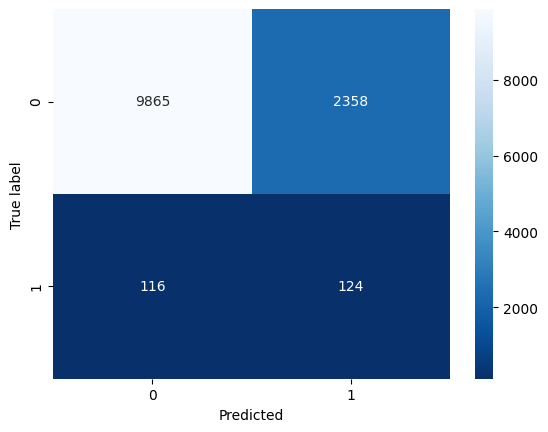

In [91]:
#построи матрицу ошибок
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues_r')
plt.ylabel('True label')
plt.xlabel('Predicted'); 

In [92]:
# проводим оценку точности
acc = accuracy_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
print('accuracy: ',round(acc ,3))
print('recall: ',round(recall ,3))
print('precision: ',round(precision,3))

accuracy:  0.801
recall:  0.517
precision:  0.05


При высоком значении accuracy, только в 51,7% случаев предсказывает правильно положительный класс. В нашем случае необходимо повысить recall, чтобы получить 100% положительных результатов, то есть найти всех клиентов, которые совершат покупку. Для более глубокого анализа необходимо знать стоимость отправки сообщений и средний чек покупки, чтобы вычислить выгоду и скорректировать порог. Для текущих данных установим recall = 1.

In [101]:
data_1 = pd.DataFrame(zip(y_test, y_test_pred),
             columns = ['y_valid', 'y_proba']).sort_values(by='y_proba',ascending=True)
data_1.head(10)

,y_valid,y_proba
11000,0,0.233791
3738,0,0.235188
11955,0,0.236049
887,0,0.237980
10248,0,0.238674
136,0,0.239357
9601,0,0.241000
8376,0,0.241023
1759,0,0.243235
5334,0,0.243272


In [102]:
thresholds = [round(i,2) for i in np.linspace(0.1,3,num = 50,endpoint=False)]

In [103]:
# создаём переменную, которая будет хранить список новых колонок
columns = []

# добавьте столбцы с новыми предсказаниями в таблицу
for i in thresholds:
    columns.append('y_pred_'+str(i))
    data_1['y_pred_'+str(i)] = data_1['y_proba'].apply(lambda x:1  if x > i else 0)
    recall = recall_score(data_1['y_valid'], data_1['y_pred_'+str(i)], zero_division='warn')
    precision = precision_score(data_1['y_valid'], data_1['y_pred_'+str(i)], zero_division='warn')
    #if recall==1:
        #data_new = data['y_pred_'+str(i)]
        #break
    print('recall ' + str(i) + ':',round(recall,5))
    print('precision ' + str(i) + ':',round(precision,5))

recall 0.1: 1.0
precision 0.1: 0.01926
recall 0.16: 1.0
precision 0.16: 0.01926
recall 0.22: 1.0
precision 0.22: 0.01926
recall 0.27: 1.0
precision 0.27: 0.01945
recall 0.33: 0.98333
precision 0.33: 0.02147
recall 0.39: 0.88333
precision 0.39: 0.02601
recall 0.45: 0.71667
precision 0.45: 0.03732
recall 0.51: 0.47917
precision 0.51: 0.05213
recall 0.56: 0.3125
precision 0.56: 0.05814
recall 0.62: 0.21667
precision 0.62: 0.06341
recall 0.68: 0.11667
precision 0.68: 0.06846
recall 0.74: 0.04167
precision 0.74: 0.08264
recall 0.8: 0.00417
precision 0.8: 0.11111
recall 0.85: 0.0
precision 0.85: 0.0
recall 0.91: 0.0
precision 0.91: 0.0
recall 0.97: 0.0
precision 0.97: 0.0
recall 1.03: 0.0
precision 1.03: 0.0
recall 1.09: 0.0
precision 1.09: 0.0
recall 1.14: 0.0
precision 1.14: 0.0
recall 1.2: 0.0
precision 1.2: 0.0
recall 1.26: 0.0
precision 1.26: 0.0
recall 1.32: 0.0
precision 1.32: 0.0
recall 1.38: 0.0
precision 1.38: 0.0
recall 1.43: 0.0
precision 1.43: 0.0
recall 1.49: 0.0
precision 1.49

C:\Users\Даша\AppData\Roaming\Python\Python39\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Даша\AppData\Roaming\Python\Python39\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Даша\AppData\Roaming\Python\Python39\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Даша\AppData\Roaming\Python\Python39\site-packages\sklearn

recall 1.78: 0.0
precision 1.78: 0.0
recall 1.84: 0.0
precision 1.84: 0.0
recall 1.9: 0.0
precision 1.9: 0.0
recall 1.96: 0.0
precision 1.96: 0.0
recall 2.01: 0.0
precision 2.01: 0.0
recall 2.07: 0.0
precision 2.07: 0.0
recall 2.13: 0.0
precision 2.13: 0.0
recall 2.19: 0.0
precision 2.19: 0.0
recall 2.25: 0.0
precision 2.25: 0.0
recall 2.3: 0.0
precision 2.3: 0.0
recall 2.36: 0.0
precision 2.36: 0.0
recall 2.42: 0.0
precision 2.42: 0.0
recall 2.48: 0.0
precision 2.48: 0.0
recall 2.54: 0.0
precision 2.54: 0.0
recall 2.59: 0.0
precision 2.59: 0.0
recall 2.65: 0.0
precision 2.65: 0.0
recall 2.71: 0.0
precision 2.71: 0.0
recall 2.77: 0.0
precision 2.77: 0.0
recall 2.83: 0.0
precision 2.83: 0.0
recall 2.88: 0.0
precision 2.88: 0.0
recall 2.94: 0.0
precision 2.94: 0.0


C:\Users\Даша\AppData\Roaming\Python\Python39\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Даша\AppData\Roaming\Python\Python39\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Даша\AppData\Roaming\Python\Python39\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Даша\AppData\Roaming\Python\Python39\site-packages\sklearn

В ходе анализа было установлено, что при recall = 1, порог равен 0.27.

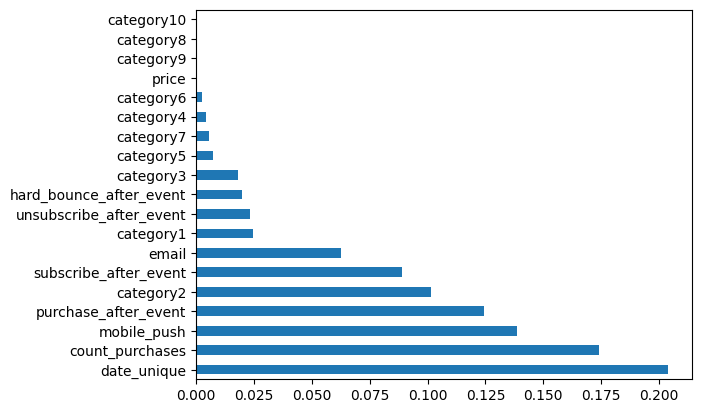

In [96]:
best_model = randomized_search.best_estimator_.steps[-1][1]
if hasattr(best_model, 'feature_importances_'):
    importances = pd.Series(best_model.feature_importances_, index=X_train.columns)
    importances.sort_values(ascending=False).plot(kind='barh')
else:
    # Создаём explainer (зависит от типа модели)
    explainer = shap.Explainer(best_model, X_train)
    shap_values = explainer(X_test)

    # График важности признаков
    shap.summary_plot(shap_values, X_test, plot_type="bar")

На основе созданного датасета и обученной модели выявили наиболее значимые признаки.

# Итог

В рамках текущего проекта было проведено исследование истории покупок и рассылок для определения вероятности повтороной покупки в течение следующих 90 дней.
Для проведения исследования были обработаны исходные датафреймы и создан новый датасет с новыми признаками:
- общее количество покупок,
- средний чек покупок,
- сколько раз произведена покупка после рассылки,
- сколько раз подписался на рассылку,
- сколько раз отписался от рассылки,
- сколько раз письмо не было доставлено,
- сколько раз была совершена покупка в разные дни,
- сколько рассылок получено по email,
- сколько рассылок получено по mobile_push,
- покупки по категориям (10 столбцов со значениями категорий из первого значения списка столбца category_ids таблицы purchases)

На основе полученных признаков была обучена модель RandomForestClassifier и рассчитаны предсказания. Метрика ROC-AUC на тестовой выборке: 0.73. Метрики recall и precision достаточно низкие, recall = 1 при пороге 0,27, что даст большое количество ложно-положительных случаев. Следует еще доработать модель, рассмотреть возможность добавления других признаков. Также для более глубокого анализа необходимо знать стоимость отправки сообщений и средний чек покупки, чтобы вычислить выгоду и скорректировать порог.